# **2502014210 - Eleanor Maritsa Maharani**

# **No. 1a**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.activations import relu
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.metrics import make_scorer

Pada kasus ini saya hanya akan menggunakan kolom date dan close saja. Kedua dataset timeseries yang saya dapatkan yaitu dataset AMZN dan dataset CSCO

In [2]:
# Membaca dataset AMZN.csv
df_amzn = pd.read_csv('AMZN.csv', usecols=['Date', 'Close'])
df_amzn['Date'] = pd.to_datetime(df_amzn['Date'])  # Mengubah kolom Date menjadi tipe datetime
df_amzn.set_index('Date', inplace=True)  # Menggunakan kolom Date sebagai index

Pada dataset AMZN kolom close memiliki 5758 records dengan tipe data float

In [3]:
# Eksplorasi data AMZN
print("Info dataset AMZN:")
print(df_amzn.info())

Info dataset AMZN:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5758 entries, 1997-05-15 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5758 non-null   float64
dtypes: float64(1)
memory usage: 90.0 KB
None


In [4]:
print("Statistik deskriptif dataset AMZN:")
print(df_amzn.describe())

Statistik deskriptif dataset AMZN:
             Close
count  5758.000000
mean    340.417580
std     523.140207
min       1.395833
25%      37.562500
50%      81.599998
75%     334.290001
max    2170.219971


In [5]:
print("Lima data teratas dataset AMZN:")
print(df_amzn.head())

Lima data teratas dataset AMZN:
               Close
Date                
1997-05-15  1.958333
1997-05-16  1.729167
1997-05-19  1.708333
1997-05-20  1.635417
1997-05-21  1.427083


Pada dataset AMZN tidak ditemukan missing value

In [6]:
# Mengecek jumlah nilai yang hilang pada setiap kolom
print(df_amzn.isnull().sum())

Close    0
dtype: int64


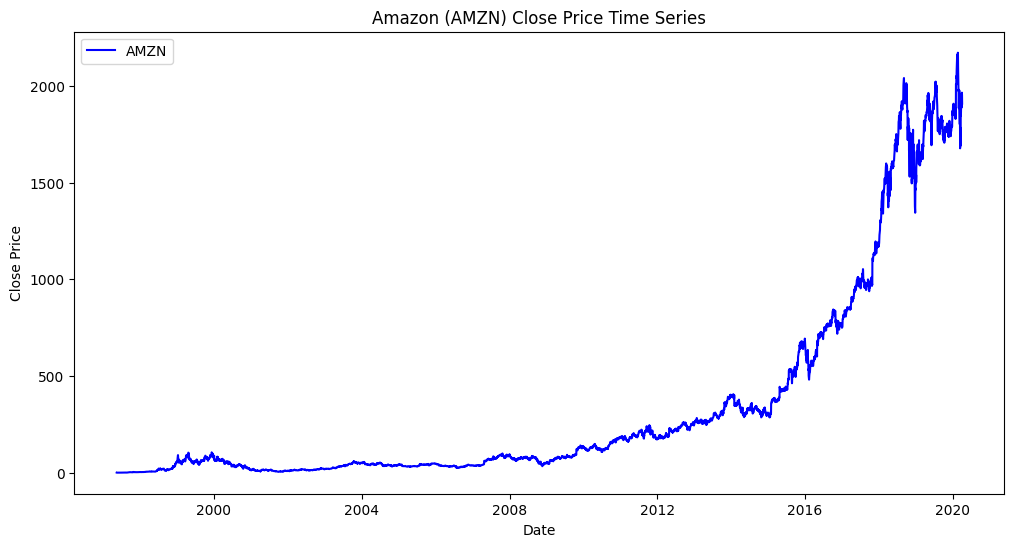

In [7]:
# Visualisasi data time series AMZN
plt.figure(figsize=(12, 6))
plt.plot(df_amzn.index, df_amzn['Close'], label='AMZN', color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Amazon (AMZN) Close Price Time Series')
plt.legend()
plt.show()

Disini saya akan memisahkan data time series menjadi input dan output. Input atau window size adalah jumlah langkah waktu dari data historis yang digunakan untuk memprediksi. Window size saya inisialisasi 5, karena saya mau mengambil dari hari senin sampai dengan hari jumat. Output atau horizon adalah jumlah langkah waktu untuk memprediksi ke masa depan. Horizon saya inisialisas 1 karena hanya untuk hari senin saja.

In [8]:
# Split function
def split_data_time_series(df, window_size, horizon):
    x, y = [], []
    for i in range(len(df) - window_size - horizon + 1):
        x.append(df.iloc[i:i+window_size]['Close'].values)
        y.append(df.iloc[i+window_size+horizon-1]['Close'])
    return np.array(x), np.array(y)

In [9]:
window_size = 5
horizon = 1

In [10]:
# Menggunakan fungsi split_data_time_series untuk memisahkan data AMZN
x_amzn, y_amzn = split_data_time_series(df_amzn, window_size, horizon)

**Problem data : scalling data**

Scaling data adalah proses transformasi data sehingga nilainya memiliki rentang yang sama atau setidaknya skalanya serupa. Teknik penskalaan data yang akan saya gunakan adalah normalisasi min-max scaling. Alasan
menggunakan teknik penskalaan min-max karena teknik ini mengubah nilai numerik menjadi rentang 0 hingga 1, sehingga semua fitur memiliki rentang nilai dan
tidak mempengaruhi kinerja model. Scalling data perlu dilakukan karena jika ada variabel numerik dengan skala yang berbeda-beda pada dataset perlu dilakukan scaling data agar skala variabel tersebut seimbang dan dapat digunakan dalam model.

In [11]:
# Skalasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
x_amzn = scaler.fit_transform(x_amzn)
y_amzn = scaler.fit_transform(y_amzn.reshape(-1, 1))

In [12]:
# Menampilkan contoh input dan output
print("Contoh input AMZN:")
print(x_amzn[1])  # Contoh input pertama dari AMZN
print("\nOutput yang sesuai untuk contoh input AMZN:")
print(y_amzn[1])  # Output yang sesuai untuk contoh input pertama dari AMZN\

Contoh input AMZN:
[1.53693076e-04 1.44087293e-04 1.10466888e-04 1.44087293e-05
 0.00000000e+00]

Output yang sesuai untuk contoh input AMZN:
[4.80290795e-05]


In [13]:
from sklearn.model_selection import train_test_split

Memisahkan dataset menjadi train, test dan validation set dengan ketentuan 80 train, 10 val, 10 test


In [14]:
# Pisahkan data AMZN menjadi train, validation, dan test set
X_train_amzn, X_temp_amzn, y_train_amzn, y_temp_amzn = train_test_split(x_amzn, y_amzn, test_size=0.2, random_state=42)
X_val_amzn, X_test_amzn, y_val_amzn, y_test_amzn = train_test_split(X_temp_amzn, y_temp_amzn, test_size=0.5, random_state=42)

In [15]:
# Menampilkan jumlah data pada setiap set
print("Jumlah data dalam setiap set:")
print("Train set (AMZN):", len(X_train_amzn))
print("Validation set (AMZN):", len(X_val_amzn))
print("Test set (AMZN):", len(X_test_amzn))

Jumlah data dalam setiap set:
Train set (AMZN): 4602
Validation set (AMZN): 575
Test set (AMZN): 576


In [16]:
# Ubah bentuk data agar sesuai dengan input yang diperlukan oleh LSTM (jumlah data, jumlah time steps, jumlah fitur)
X_train_amzn = X_train_amzn.reshape(X_train_amzn.shape[0], window_size, 1)
X_test_amzn = X_test_amzn.reshape(X_test_amzn.shape[0], window_size, 1)
X_val_amzn = X_val_amzn.reshape(X_val_amzn.shape[0], window_size, 1)

# **No. 1b - AMZN**

Membuat arsitektur baseline dengan LSTM (units=50) dan layer akhir berupa node Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU

In [17]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

In [18]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [19]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
# Latih model dengan data train
modelamzn=model.fit(X_train_amzn, y_train_amzn, epochs=5, batch_size=64, validation_data=(X_val_amzn, y_val_amzn))

Epoch 1/5
72/72 [==============================] - 2s 7ms/step - loss: 0.0332 - mae: 0.1081 - val_loss: 0.0026 - val_mae: 0.0465
Epoch 2/5
72/72 [==============================] - 0s 4ms/step - loss: 3.8965e-04 - mae: 0.0135 - val_loss: 1.2959e-04 - val_mae: 0.0070
Epoch 3/5
72/72 [==============================] - 0s 4ms/step - loss: 1.0104e-04 - mae: 0.0061 - val_loss: 1.0432e-04 - val_mae: 0.0049
Epoch 4/5
72/72 [==============================] - 0s 4ms/step - loss: 8.7378e-05 - mae: 0.0050 - val_loss: 9.7132e-05 - val_mae: 0.0044
Epoch 5/5
72/72 [==============================] - 0s 4ms/step - loss: 8.3062e-05 - mae: 0.0045 - val_loss: 9.4783e-05 - val_mae: 0.0044


In [ ]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test_amzn, y_test_amzn, batch_size=64)
print("Test MSE:", results[0])

Evaluate on test data
9/9 [==============================] - 0s 3ms/step - loss: 6.2500e-05 - mae: 0.0045
Test MSE: 6.249965372262523e-05


In [26]:
# Melakukan prediksi pada data test
y_pred_amzn = model.predict(X_test_amzn)

# Menampilkan hasil prediksi
print("Predicted Values:")
print(y_pred_amzn)

18/18 [==============================] - 0s 2ms/step
Predicted Values:
[[0.16373861]
 [0.03237148]
 [0.01875058]
 [0.02577537]
 [0.03958131]
 [0.02094679]
 [0.03110025]
 [0.01710599]
 [0.40085173]
 [0.4569433 ]
 [0.14848065]
 [0.10972425]
 [0.1390023 ]
 [0.0283286 ]
 [0.23274946]
 [0.0189946 ]
 [0.15536751]
 [0.02408208]
 [0.8236798 ]
 [0.05290263]
 [0.34955913]
 [0.8014701 ]
 [0.10527873]
 [0.01940142]
 [0.89146537]
 [0.0251525 ]
 [0.35063112]
 [0.11297817]
 [0.00478641]
 [0.00348775]
 [0.07738731]
 [0.02041113]
 [0.04243191]
 [0.02017161]
 [0.00412962]
 [0.00865368]
 [0.16027144]
 [0.03377822]
 [0.82172847]
 [0.03168599]
 [0.01710985]
 [0.19889207]
 [0.19720523]
 [0.00383657]
 [0.00482799]
 [0.31651968]
 [0.00369013]
 [0.75762427]
 [0.11905486]
 [0.03639422]
 [0.03420278]
 [0.2196061 ]
 [0.08201177]
 [0.27850217]
 [0.13857451]
 [0.00277586]
 [0.04227838]
 [0.17772834]
 [0.01474932]
 [0.05896948]
 [0.02236107]
 [0.6459702 ]
 [0.04010871]
 [0.03507708]
 [0.01678898]
 [0.37790522]
 [0.0

In [27]:
# Mengubah hasil prediksi kembali ke skala semula
y_pred_inverse_amzn = scaler.inverse_transform(y_pred_amzn)
y_test_inverse_amzn = scaler.inverse_transform(y_test_amzn)

# Menampilkan hasil prediksi dalam skala semula
print("Predicted Values (Inverse Transform):")
print(y_pred_inverse_amzn)

Predicted Values (Inverse Transform):
[[ 356.51608  ]
 [  71.60389  ]
 [  42.06254  ]
 [  57.298088 ]
 [  87.24074  ]
 [  46.825745 ]
 [  68.8468   ]
 [  38.495716 ]
 [ 870.7727   ]
 [ 992.4255   ]
 [ 323.4243   ]
 [ 239.36842  ]
 [ 302.86737  ]
 [  62.835598 ]
 [ 506.1885   ]
 [  42.591774 ]
 [ 338.36066  ]
 [  53.62563  ]
 [1787.8125   ]
 [ 116.13233  ]
 [ 759.5281   ]
 [1739.6436   ]
 [ 229.72688  ]
 [  43.4741   ]
 [1934.8275   ]
 [  55.947193 ]
 [ 761.853    ]
 [ 246.42561  ]
 [  11.77671  ]
 [   8.960139 ]
 [ 169.23529  ]
 [  45.663986 ]
 [  93.42318  ]
 [  45.14452  ]
 [  10.352243 ]
 [  20.164146 ]
 [ 348.9964   ]
 [  74.654854 ]
 [1783.5804   ]
 [  70.11718  ]
 [  38.50409  ]
 [ 432.75778  ]
 [ 429.0993   ]
 [   9.71668  ]
 [  11.866887 ]
 [ 687.87134  ]
 [   9.399085 ]
 [1644.5497   ]
 [ 259.6049   ]
 [  80.3285   ]
 [  75.57565  ]
 [ 477.68286  ]
 [ 179.26492  ]
 [ 605.418    ]
 [ 301.9396   ]
 [   7.416188 ]
 [  93.0902   ]
 [ 386.85736  ]
 [  33.38451  ]
 [ 129.29027  ]
 [

In [24]:
# Menampilkan nilai Close yang sebenarnya (skala semula)
print("Actual Values:")
print(y_test_inverse_amzn)

Actual Values:
[[3.58739990e+02]
 [6.80000000e+01]
 [3.76899986e+01]
 [5.33125000e+01]
 [9.05599976e+01]
 [5.68100014e+01]
 [7.01699982e+01]
 [4.11250000e+01]
 [8.52969971e+02]
 [9.69859985e+02]
 [3.34380005e+02]
 [2.44850006e+02]
 [2.95059998e+02]
 [6.30625000e+01]
 [5.16890015e+02]
 [3.90999985e+01]
 [3.29750000e+02]
 [4.93400002e+01]
 [1.82354004e+03]
 [1.09260002e+02]
 [7.80000000e+02]
 [1.73565002e+03]
 [2.23229996e+02]
 [4.18600006e+01]
 [1.96394995e+03]
 [5.71599998e+01]
 [7.41200012e+02]
 [2.51250000e+02]
 [6.55729151e+00]
 [4.50000000e+00]
 [1.76429993e+02]
 [4.30999985e+01]
 [9.52099991e+01]
 [4.39599991e+01]
 [4.90625000e+00]
 [1.70100002e+01]
 [3.61790009e+02]
 [7.64599991e+01]
 [1.77342004e+03]
 [7.30000000e+01]
 [3.54700012e+01]
 [4.43510010e+02]
 [4.26950012e+02]
 [4.16666651e+00]
 [7.05000019e+00]
 [6.75890015e+02]
 [3.92187500e+00]
 [1.65838000e+03]
 [2.75589996e+02]
 [8.38799973e+01]
 [7.29599991e+01]
 [4.88269989e+02]
 [1.85479996e+02]
 [6.26549988e+02]
 [3.03910004e

In [28]:
import numpy as np

# Menghitung RMSE
rmse = np.sqrt(np.mean((y_pred_inverse_amzn - y_test_inverse_amzn)**2))

# Menghitung MAE
mae = np.mean(np.abs(y_pred_inverse_amzn - y_test_inverse_amzn))

# Menghitung MAPE
mape = np.mean(np.abs((y_test_inverse_amzn - y_pred_inverse_amzn) / y_test_inverse_amzn)) * 100

# Menampilkan hasil evaluasi
print("RMSE on Test Data:", rmse)
print("MAE on Test Data:", mae)
print("MAPE on Test Data:", mape)

RMSE on Test Data: 20.650520825819033
MAE on Test Data: 10.060721353731221
MAPE on Test Data: 13.862660145821687


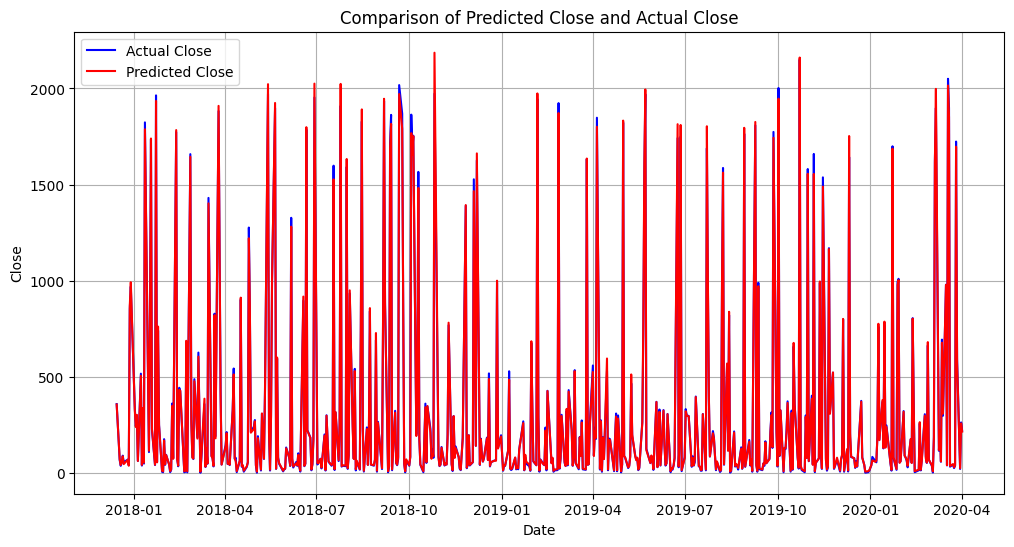

In [29]:
import matplotlib.pyplot as plt

# Mengambil tanggal dari data test
test_dates_amzn = df_amzn.index[-len(y_test_inverse_amzn):]

# Plot hasil prediksi dan nilai Close yang sebenarnya
plt.figure(figsize=(12, 6))
plt.plot(test_dates_amzn, y_test_inverse_amzn, label='Actual Close', color='blue')
plt.plot(test_dates_amzn, y_pred_inverse_amzn, label='Predicted Close', color='red')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Comparison of Predicted Close and Actual Close')
plt.legend()
plt.grid(True)
plt.show()

# **No. 1c - AMAZN**

Saya menggunakan metode grid search untuk menemukan nilai hyperparameter yang optimal karena grid search dapat secara
sistematis mengevaluasi berbagai kombinasi nilai hyperparameter dan memilih kombinasi
yang menghasilkan kinerja model terbaik sehingga membantu menghemat waktu dan
sumber daya karena mencari nilai hiperparameter optimal secara manual dapat memakan
waktu yang lama.
Untuk memperbaiki kinerja model, terdapat beberapa pendekatan yang dapat dilakukan
seperti:
1. Menambah atau mengurangi layer pada model
2. Mengubah jumlah neuron pada setiap layer
3. Mengubah learning rate pada optimizer
4. Menggunakan teknik regularisasi seperti dropout atau L2 regularization
5. Memilih metrik evaluasi yang lebih tepat
Berikut adalah beberapa perubahan yang dapat dilakukan pada arsitektur baseline untuk
meningkatkan kinerjanya:
6. Menambahkan layer Dropout: Layer dropout dapat membantu mencegah overfitting
dengan secara acak menghilangkan neuron selama pelatihan.

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from keras.layers import Dropout

In [ ]:
# Fungsi untuk membangun model LSTM
def build_lstm_model(units =50, activation = 'relu', learning_rate=0.001, dropout=0.0):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Membungkus model dengan KerasRegressor agar dapat digunakan dengan GridSearchCV
lstm_model = KerasRegressor(build_fn=build_lstm_model, verbose=0)

<ipython-input-48-ca58bac11d11>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=build_lstm_model, verbose=0)


In [ ]:
# Menentukan hyperparameter yang akan diuji
param_grid = {
    'units': [32, 64],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout': [0.0, 0.2],
    'epochs': [10, 20]
}

In [ ]:
# Membangun objek GridSearchCV untuk dataset AMZN
grid_search_amzn = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)

In [ ]:
grid_search_amzn.fit(X_train_amzn, y_train_amzn)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc8adb715d0>,
             param_grid={'activation': ['relu', 'tanh'], 'dropout': [0.0, 0.2],
                         'epochs': [10, 20],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'units': [32, 64]})

In [ ]:
# Menampilkan hasil pencarian kombinasi terbaik untuk dataset AMZN
print("Best Parameters for AMZN:", grid_search_amzn.best_params_)
print("Best Score (RMSE) for AMZN:", np.sqrt(-grid_search_amzn.best_score_))

Best Parameters for AMZN: {'activation': 'tanh', 'dropout': 0.0, 'epochs': 10, 'learning_rate': 0.1, 'units': 32}
Best Score (RMSE) for AMZN: 0.006721167045739181


Dari hasil di atas diperoleh bahwa parameter terbaik yang menghasikan akurasi optimal
adalah
1. 'epochs': 10,
2. 'optimizer': 'adam' dengan 'learn_rate': 0.01
3. 'Units' : 32
4. 'activation' : 'tanh'

**Model arsitektur modifikasi**

In [ ]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(1))

In [ ]:
from tensorflow.keras.optimizers import Adam

# Kompilasi model
optimizer = Adam(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
print(model.summary())

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 32)                4352      
                                                                 
 dense_147 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Latih model dengan data train
modelamzn=model.fit(X_train_amzn, y_train_amzn, epochs=10, batch_size=32)

Epoch 1/10
144/144 [==============================] - 2s 11ms/step - loss: 6.8733e-05 - mae: 0.0055
Epoch 2/10
144/144 [==============================] - 1s 9ms/step - loss: 1.2039e-04 - mae: 0.0080
Epoch 3/10
144/144 [==============================] - 1s 7ms/step - loss: 1.6743e-04 - mae: 0.0089
Epoch 4/10
144/144 [==============================] - 1s 5ms/step - loss: 1.0699e-04 - mae: 0.0072
Epoch 5/10
144/144 [==============================] - 1s 5ms/step - loss: 1.1527e-04 - mae: 0.0077
Epoch 6/10
144/144 [==============================] - 1s 4ms/step - loss: 6.2729e-05 - mae: 0.0053
Epoch 7/10
144/144 [==============================] - 1s 5ms/step - loss: 1.0720e-04 - mae: 0.0074
Epoch 8/10
144/144 [==============================] - 1s 5ms/step - loss: 1.0751e-04 - mae: 0.0069
Epoch 9/10
144/144 [==============================] - 1s 5ms/step - loss: 7.9258e-05 - mae: 0.0058
Epoch 10/10
144/144 [==============================] - 1s 5ms/step - loss: 7.9482e-05 - mae: 0.0063


In [ ]:
# Melakukan prediksi menggunakan model terbaik untuk dataset AMZN
best_model_amzn = grid_search_amzn.best_estimator_
y_pred_amzn = best_model_amzn.predict(X_test_amzn)

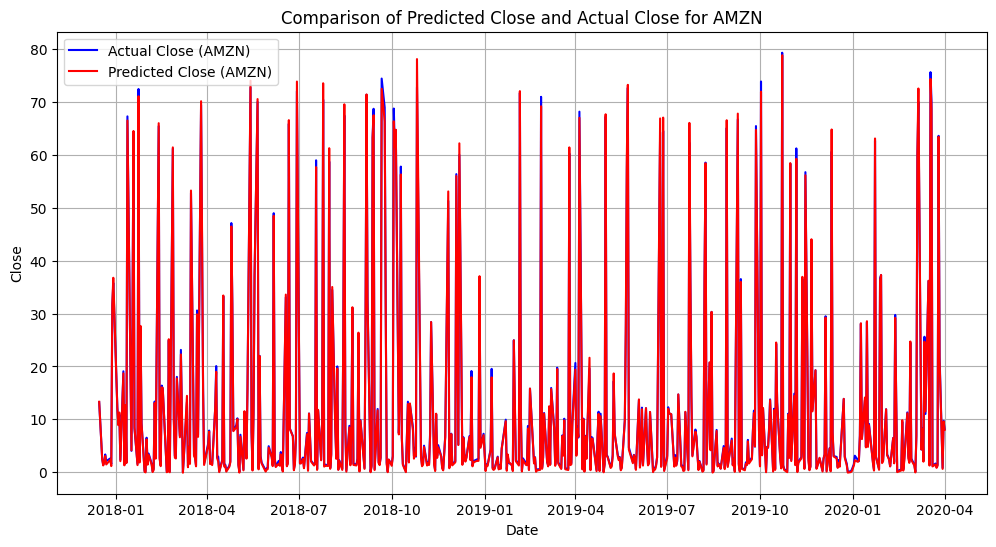

In [ ]:
# Menampilkan plot hasil prediksi dan nilai Close yang sebenarnya untuk dataset AMZN
plt.figure(figsize=(12, 6))
plt.plot(test_dates_amzn, y_test_inverse_amzn, label='Actual Close (AMZN)', color='blue')
plt.plot(test_dates_amzn, y_pred_inverse_amzn, label='Predicted Close (AMZN)', color='red')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Comparison of Predicted Close and Actual Close for AMZN')
plt.legend()
plt.grid(True)
plt.show()

# **NO. 1D - AMZN**

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluasi LSTM biasa untuk dataset AMZN
y_pred_lstm_amzn = model.predict(X_test_amzn)
y_pred_inverse_lstm_amzn = scaler.inverse_transform(y_pred_lstm_amzn)
y_test_inverse_amzn = scaler.inverse_transform(y_test_amzn)

rmse_lstm_amzn = np.sqrt(mean_squared_error(y_test_inverse_amzn, y_pred_inverse_lstm_amzn))
mae_lstm_amzn = mean_absolute_error(y_test_inverse_amzn, y_pred_inverse_lstm_amzn)
mape_lstm_amzn = np.mean(np.abs((y_test_inverse_amzn - y_pred_inverse_lstm_amzn) / y_test_inverse_amzn)) * 100

print("Performance of LSTM Architecture for AMZN:")
print("RMSE:", rmse_lstm_amzn)
print("MAE:", mae_lstm_amzn)
print("MAPE:", mape_lstm_amzn)

18/18 [==============================] - 0s 7ms/step
Performance of LSTM Architecture for AMZN:
RMSE: 20.650520825819033
MAE: 10.060721353731221
MAPE: 13.862660145821687


In [ ]:
# Evaluasi LSTM dengan modifikasi GridSearch untuk dataset AMZN
y_pred_gridsearch_amzn = best_model_amzn.predict(X_test_amzn)
y_pred_inverse_gridsearch_amzn = scaler.inverse_transform(y_pred_gridsearch_amzn.reshape(-1, 1))

rmse_gridsearch_amzn = np.sqrt(mean_squared_error(y_test_inverse_amzn, y_pred_inverse_gridsearch_amzn))
mae_gridsearch_amzn = mean_absolute_error(y_test_inverse_amzn, y_pred_inverse_gridsearch_amzn)
mape_gridsearch_amzn = np.mean(np.abs((y_test_inverse_amzn - y_pred_inverse_gridsearch_amzn) / y_test_inverse_amzn)) * 100

print("Performance of LSTM Architecture with GridSearch for AMZN:")
print("RMSE:", rmse_gridsearch_amzn)
print("MAE:", mae_gridsearch_amzn)
print("MAPE:", mape_gridsearch_amzn)

Performance of LSTM Architecture with GridSearch for AMZN:
RMSE: 0.6307800071601061
MAE: 0.33040755221125595
MAPE: 11.289919143930744


RMSE (Root Mean Squared Error): Nilai RMSE menggambarkan tingkat kesalahan prediksi dalam satuan yang sama dengan variabel target. Semakin rendah nilai RMSE, semakin baik model dalam memprediksi nilai Close yang sebenarnya. Jadi, kita membandingkan nilai RMSE antara kedua arsitektur LSTM. Hasil RMSE LSTM dengan modifikasi GridSearch lebih rendah, itu menunjukkan bahwa model tersebut memberikan prediksi yang lebih akurat.
RMSE model arsitektur baseline: 20.65
RMSE model arsitektur modifikasi : 0.63

MAE (Mean Absolute Error): Nilai MAE merupakan nilai rata-rata dari selisih absolut antara nilai prediksi dan nilai Close yang sebenarnya. Semakin rendah nilai MAE, semakin baik model dalam memprediksi nilai Close yang sebenarnya. Kita dapat membandingkan nilai MAE antara kedua arsitektur LSTM dan dapat kita lihat bahwa nilai MAE pada gridsearch lebih rendah (0.3304) jadi model ini lebih memberikan prediksi yang akurat  mana yang memiliki MAE yang lebih rendah untuk menentukan model yang lebih baik.

MAPE adalah singkatan dari "Mean Absolute Percentage Error" atau "Kesalahan Persentase Mutlak Rata-Rata". Ini adalah metrik yang digunakan untuk mengukur tingkat kesalahan atau ketidakakuratan dalam ramalan atau perkiraan. Pada arsitektur gridsearch mendapatkan nilai MAPE yang lebih rendah (11.2899) daripada arsitektur baseline (13.86)

Dengan ini maka model arsitektur yang sudah dimodifikasi menggunakan hyperparameter tunning gridsearch lebih cocok daripada menggunakan model arsitektur baseline.

# **No. 1e**

Link Google Colab: https://drive.google.com/drive/folders/1fVu56rHJ7ojt87U3utHyqixNhaPjlbd7?usp=sharing

# **2502014210 - Eleanor Maritsa Maharani**

# **No. 1a**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.activations import relu
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.layers import Dense, Dropout
from sklearn.metrics import make_scorer

Pada kasus ini saya hanya akan menggunakan kolom date dan close saja. Kedua dataset timeseries yang saya dapatkan yaitu dataset AMZN dan dataset CSCO

In [2]:
# Membaca dataset CSCO.csv
df_csco = pd.read_csv('CSCO.csv', usecols=['Date', 'Close'])
df_csco['Date'] = pd.to_datetime(df_csco['Date'])  # Mengubah kolom Date menjadi tipe datetime
df_csco.set_index('Date', inplace=True)  # Menggunakan kolom Date sebagai index

Pada dataset CSCO, kolom close memiliki 7589 records dengan tipe data float

In [4]:
# Eksplorasi data CSCO
print("Info dataset CSCO:")
print(df_csco.info())

Info dataset CSCO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7589 entries, 1990-02-16 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7589 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB
None


In [5]:
print("Statistik deskriptif dataset CSCO:")
print(df_csco.describe())

Statistik deskriptif dataset CSCO:
             Close
count  7589.000000
mean     20.399541
std      14.906589
min       0.071181
25%       8.479167
50%      19.680000
75%      27.120001
max      80.062500


In [6]:
print("Lima data teratas dataset CSCO:")
print(df_csco.head())

Lima data teratas dataset CSCO:
               Close
Date                
1990-02-16  0.077257
1990-02-20  0.079861
1990-02-21  0.078125
1990-02-22  0.078993
1990-02-23  0.078559


Dataset CSCO juga tidak memiliki missing value

In [7]:
# Mengecek jumlah nilai yang hilang pada setiap kolom
print(df_csco.isnull().sum())

Close    0
dtype: int64


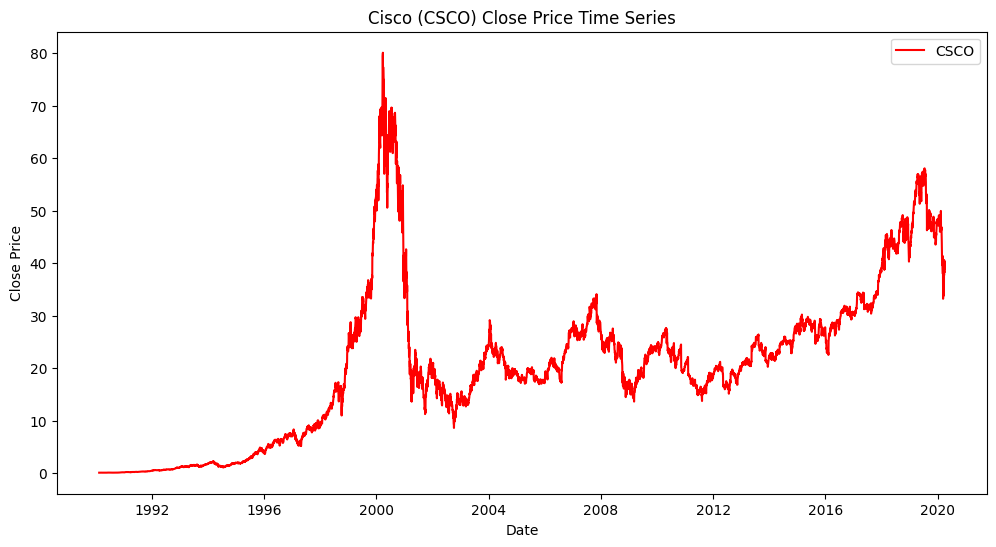

In [8]:
# Visualisasi data time series CSCO
plt.figure(figsize=(12, 6))
plt.plot(df_csco.index, df_csco['Close'], label='CSCO', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Cisco (CSCO) Close Price Time Series')
plt.legend()
plt.show()


Disini saya akan memisahkan data time series menjadi input dan output. Input atau window size adalah jumlah langkah waktu dari data historis yang digunakan untuk memprediksi. Window size saya inisialisasi 5, karena saya mau mengambil dari hari senin sampai dengan hari jumat. Output atau horizon adalah jumlah langkah waktu untuk memprediksi ke masa depan. Horizon saya inisialisas 1 karena hanya untuk hari senin saja.

In [9]:
# Split function
def split_data_time_series(df, window_size, horizon):
    x, y = [], []
    for i in range(len(df) - window_size - horizon + 1):
        x.append(df.iloc[i:i+window_size]['Close'].values)
        y.append(df.iloc[i+window_size+horizon-1]['Close'])
    return np.array(x), np.array(y)

In [10]:
window_size = 5
horizon = 1

In [11]:
# Menggunakan fungsi split_data_time_series untuk memisahkan data CSCO
x_csco, y_csco = split_data_time_series(df_csco, window_size, horizon)

**Problem data : scalling data**

Scaling data adalah proses transformasi data sehingga nilainya memiliki rentang yang sama atau setidaknya skalanya serupa. Teknik penskalaan data yang akan saya gunakan adalah normalisasi min-max scaling. Alasan
menggunakan teknik penskalaan min-max karena teknik ini mengubah nilai numerik menjadi rentang 0 hingga 1, sehingga semua fitur memiliki rentang nilai dan
tidak mempengaruhi kinerja model. Scalling data perlu dilakukan karena jika ada variabel numerik dengan skala yang berbeda-beda pada dataset perlu dilakukan scaling data agar skala variabel tersebut seimbang dan dapat digunakan dalam model.

In [13]:
# Skalasi data menggunakan MinMaxScaler
scaler = MinMaxScaler()
x_csco = scaler.fit_transform(x_csco)
y_csco = scaler.fit_transform(y_csco.reshape(-1, 1))

In [14]:
print("Contoh input CSCO:")
print(x_csco[0])  # Contoh input pertama dari CSCO
print("\nOutput yang sesuai untuk contoh input CSCO:")
print(y_csco[0])  # Output yang sesuai untuk contoh input pertama dari CSCO

Contoh input CSCO:
[7.59631864e-05 1.08518771e-04 8.68150170e-05 9.76668475e-05
 9.22409323e-05]

Output yang sesuai untuk contoh input CSCO:
[6.51112627e-05]


In [15]:
from sklearn.model_selection import train_test_split

Memisahkan dataset menjadi train, test dan validation set dengan ketentuan 80 train, 10 val, 10 test


In [16]:
# Pisahkan data CSCO menjadi train, validation, dan test set
X_train_csco, X_temp_csco, y_train_csco, y_temp_csco = train_test_split(x_csco, y_csco, test_size=0.2, random_state=42)
X_val_csco, X_test_csco, y_val_csco, y_test_csco = train_test_split(X_temp_csco, y_temp_csco, test_size=0.5, random_state=42)

In [17]:
# Menampilkan jumlah data pada setiap set
print("Jumlah data dalam setiap set:")
print("Train set (CSCO):", len(X_train_csco))
print("Validation set (CSCO):", len(X_val_csco))
print("Test set (CSCO):", len(X_test_csco))

Jumlah data dalam setiap set:
Train set (CSCO): 6067
Validation set (CSCO): 758
Test set (CSCO): 759


In [23]:
# Ubah bentuk data agar sesuai dengan input yang diperlukan oleh LSTM (jumlah data, jumlah time steps, jumlah fitur)
X_train_csco = X_train_csco.reshape(X_train_csco.shape[0], window_size, 1)
X_test_csco = X_test_csco.reshape(X_test_csco.shape[0], window_size, 1)
X_val_csco = X_val_csco.reshape(X_val_csco.shape[0], window_size, 1)

# **No. 1B - CSCO**

Membuat arsitektur baseline dengan LSTM (units=50) dan layer akhir berupa node Perceptron dengan units=1. Activation function untuk LSTM menggunakan ReLU

In [24]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

In [25]:
# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [26]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# Latih model dengan data train
model.fit(X_train_csco, y_train_csco, epochs=5, batch_size=32, validation_data=(X_val_csco, y_val_csco))

Epoch 1/5
190/190 [==============================] - 2s 8ms/step - loss: 9.2633e-05 - mae: 0.0058 - val_loss: 7.8968e-05 - val_mae: 0.0052
Epoch 2/5
190/190 [==============================] - 1s 7ms/step - loss: 9.5913e-05 - mae: 0.0063 - val_loss: 8.0703e-05 - val_mae: 0.0052
Epoch 3/5
190/190 [==============================] - 1s 5ms/step - loss: 8.7541e-05 - mae: 0.0056 - val_loss: 1.0395e-04 - val_mae: 0.0067
Epoch 4/5
190/190 [==============================] - 1s 5ms/step - loss: 9.2041e-05 - mae: 0.0060 - val_loss: 1.1933e-04 - val_mae: 0.0079
Epoch 5/5
190/190 [==============================] - 1s 5ms/step - loss: 9.3112e-05 - mae: 0.0059 - val_loss: 8.8984e-05 - val_mae: 0.0063


In [28]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test_csco, y_test_csco, batch_size=64)
print("Test MSE:", results[0])

Evaluate on test data
12/12 [==============================] - 0s 3ms/step - loss: 6.8436e-05 - mae: 0.0050
Test MSE: 6.843644223408774e-05


In [33]:
# Melakukan prediksi pada data test
y_pred_csco = model.predict(X_test_csco)

# Menampilkan hasil prediksi
print("Predicted Values:")
print(y_pred_csco)

24/24 [==============================] - 0s 2ms/step
Predicted Values:
[[0.05585746]
 [0.24428965]
 [0.01920731]
 [0.7018409 ]
 [0.20582461]
 [0.3139723 ]
 [0.7124329 ]
 [0.54325926]
 [0.8325493 ]
 [0.40888888]
 [0.6252383 ]
 [0.8096414 ]
 [0.29978436]
 [0.6948901 ]
 [0.40078574]
 [0.02316147]
 [0.19943959]
 [0.333094  ]
 [0.02646684]
 [0.16987573]
 [0.38284248]
 [0.30562997]
 [0.2569818 ]
 [0.24457268]
 [0.06316809]
 [0.01250701]
 [0.7977876 ]
 [0.00845774]
 [0.30592692]
 [0.07940407]
 [0.00679491]
 [0.3197508 ]
 [0.24871954]
 [0.40199816]
 [0.00560926]
 [0.00569728]
 [0.3725223 ]
 [0.32460576]
 [0.2767042 ]
 [0.2169679 ]
 [0.05179054]
 [0.26348028]
 [0.35249275]
 [0.35508698]
 [0.01085307]
 [0.36694533]
 [0.3615694 ]
 [0.00578414]
 [0.00557354]
 [0.380104  ]
 [0.869349  ]
 [0.00556642]
 [0.5955955 ]
 [0.00711731]
 [0.62724775]
 [0.35254377]
 [0.02874692]
 [0.36238492]
 [0.81911117]
 [0.00589304]
 [0.35054433]
 [0.30365586]
 [0.02182649]
 [0.19804536]
 [0.33167022]
 [0.04452807]
 [0.3

In [34]:
# Mengubah hasil prediksi kembali ke skala semula
y_pred_inverse_csco = scaler.inverse_transform(y_pred_csco)
y_test_inverse_csco = scaler.inverse_transform(y_test_csco)

# Menampilkan hasil prediksi dalam skala semula
print("Predicted Values (Inverse Transform):")
print(y_pred_inverse_csco)

Predicted Values (Inverse Transform):
[[ 4.5392923 ]
 [19.612232  ]
 [ 1.6075987 ]
 [56.212357  ]
 [16.535362  ]
 [25.18624   ]
 [57.059628  ]
 [43.527206  ]
 [66.66789   ]
 [32.778744  ]
 [50.084816  ]
 [64.835464  ]
 [24.051329  ]
 [55.656353  ]
 [32.13056   ]
 [ 1.9238974 ]
 [16.024616  ]
 [26.71581   ]
 [ 2.1882975 ]
 [13.659764  ]
 [30.695257  ]
 [24.518927  ]
 [20.627495  ]
 [19.634872  ]
 [ 5.124079  ]
 [ 1.0716325 ]
 [63.887264  ]
 [ 0.74772596]
 [24.542679  ]
 [ 6.4228168 ]
 [ 0.6147143 ]
 [25.648468  ]
 [19.966585  ]
 [32.227547  ]
 [ 0.519873  ]
 [ 0.5269135 ]
 [29.869732  ]
 [26.036825  ]
 [22.205114  ]
 [17.42673   ]
 [ 4.2139745 ]
 [21.147316  ]
 [28.267542  ]
 [28.475058  ]
 [ 0.9393319 ]
 [29.423622  ]
 [28.993595  ]
 [ 0.53386146]
 [ 0.51701516]
 [30.476202  ]
 [69.61155   ]
 [ 0.5164455 ]
 [47.713646  ]
 [ 0.64050364]
 [50.245556  ]
 [28.271624  ]
 [ 2.3706844 ]
 [29.058828  ]
 [65.592964  ]
 [ 0.5425726 ]
 [28.111685  ]
 [24.361015  ]
 [ 1.8171105 ]
 [15.91309   ]
 [

In [35]:
# Menampilkan nilai Close yang sebenarnya (skala semula)
print("Actual Values:")
print(y_test_inverse_csco)

Actual Values:
[[4.29166651e+00]
 [1.98899994e+01]
 [1.18055558e+00]
 [5.55800018e+01]
 [1.59899998e+01]
 [2.42999992e+01]
 [5.65299988e+01]
 [4.22900009e+01]
 [6.86250000e+01]
 [3.27000008e+01]
 [4.99687500e+01]
 [6.27500000e+01]
 [2.13700008e+01]
 [5.62500000e+01]
 [3.15100002e+01]
 [1.43055558e+00]
 [1.63500004e+01]
 [2.61299992e+01]
 [1.75000000e+00]
 [1.15468750e+01]
 [3.01250000e+01]
 [2.37199993e+01]
 [2.08600006e+01]
 [1.95400009e+01]
 [4.69444466e+00]
 [5.97222209e-01]
 [6.52500000e+01]
 [3.07291657e-01]
 [2.37500000e+01]
 [5.97222233e+00]
 [1.77083328e-01]
 [2.47656250e+01]
 [1.97299995e+01]
 [3.16599998e+01]
 [8.07291642e-02]
 [9.02777761e-02]
 [2.99400005e+01]
 [2.65000000e+01]
 [2.24099998e+01]
 [1.69899998e+01]
 [3.87500000e+00]
 [2.17900009e+01]
 [2.88125000e+01]
 [2.82299995e+01]
 [4.73958343e-01]
 [2.97700005e+01]
 [2.88899994e+01]
 [1.05034724e-01]
 [7.72569478e-02]
 [2.92999992e+01]
 [6.60625000e+01]
 [7.98611119e-02]
 [4.70499992e+01]
 [2.09201396e-01]
 [4.94099998e

In [36]:
import numpy as np

# Menghitung RMSE
rmse = np.sqrt(np.mean((y_pred_inverse_csco - y_test_inverse_csco)**2))

# Menghitung MAE
mae = np.mean(np.abs(y_pred_inverse_csco - y_test_inverse_csco))

# Menghitung MAPE
mape = np.mean(np.abs((y_test_inverse_csco - y_pred_inverse_csco) / y_test_inverse_csco)) * 100

# Menampilkan hasil evaluasi
print("RMSE on Test Data:", rmse)
print("MAE on Test Data:", mae)
print("MAPE on Test Data:", mape)

RMSE on Test Data: 0.7052914338561512
MAE on Test Data: 0.5036216228905874
MAPE on Test Data: 26.95446903377363


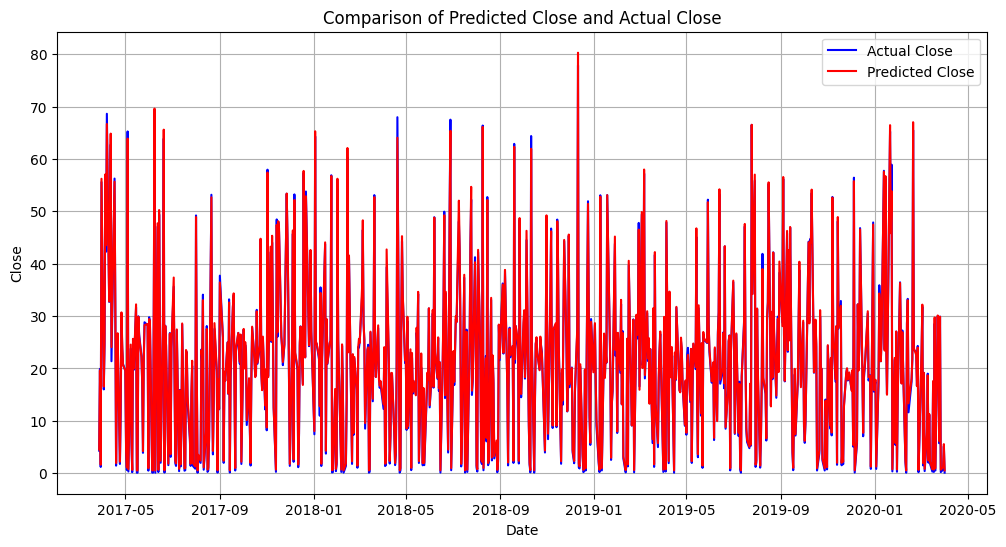

In [37]:
import matplotlib.pyplot as plt

# Mengambil tanggal dari data test
test_dates_csco = df_csco.index[-len(y_test_inverse_csco):]

# Plot hasil prediksi dan nilai Close yang sebenarnya
plt.figure(figsize=(12, 6))
plt.plot(test_dates_csco, y_test_inverse_csco, label='Actual Close', color='blue')
plt.plot(test_dates_csco, y_pred_inverse_csco, label='Predicted Close', color='red')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Comparison of Predicted Close and Actual Close')
plt.legend()
plt.grid(True)
plt.show()

# **No. 1C - CSCO**

Saya menggunakan metode grid search untuk menemukan nilai hyperparameter yang optimal karena grid search dapat secara
sistematis mengevaluasi berbagai kombinasi nilai hyperparameter dan memilih kombinasi
yang menghasilkan kinerja model terbaik sehingga membantu menghemat waktu dan
sumber daya karena mencari nilai hiperparameter optimal secara manual dapat memakan
waktu yang lama.
Untuk memperbaiki kinerja model, terdapat beberapa pendekatan yang dapat dilakukan
seperti:
1. Menambah atau mengurangi layer pada model
2. Mengubah jumlah neuron pada setiap layer
3. Mengubah learning rate pada optimizer
4. Menggunakan teknik regularisasi seperti dropout atau L2 regularization
5. Memilih metrik evaluasi yang lebih tepat
Berikut adalah beberapa perubahan yang dapat dilakukan pada arsitektur baseline untuk
meningkatkan kinerjanya:
6. Menambahkan layer Dropout: Layer dropout dapat membantu mencegah overfitting
dengan secara acak menghilangkan neuron selama pelatihan.

In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
from keras.layers import Dropout

In [ ]:
# Fungsi untuk membangun model LSTM
def build_lstm_model(units =50, activation = 'relu', learning_rate=0.001, dropout=0.0):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
# Membungkus model dengan KerasRegressor agar dapat digunakan dengan GridSearchCV
lstm_model = KerasRegressor(build_fn=build_lstm_model, verbose=0)

<ipython-input-29-ca58bac11d11>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_model = KerasRegressor(build_fn=build_lstm_model, verbose=0)


In [ ]:
# Menentukan hyperparameter yang akan diuji
param_grid = {
    'units': [32, 64],
    'activation': ['relu', 'tanh'],
    'learning_rate': [0.001, 0.01, 0.1],
    'dropout': [0.0, 0.2],
    'epochs': [10, 20]
}

In [ ]:
# Membangun objek GridSearchCV untuk dataset CSCO
grid_search_csco = GridSearchCV(estimator=lstm_model, param_grid=param_grid, cv=3)
grid_search_csco.fit(X_train_csco, y_train_csco)

GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f12912e4af0>,
             param_grid={'activation': ['relu', 'tanh'], 'dropout': [0.0, 0.2],
                         'epochs': [10, 20],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'units': [32, 64]})

In [ ]:
# Menampilkan hasil pencarian kombinasi terbaik untuk dataset AMZN
print("Best Parameters for AMZN:", grid_search_csco.best_params_)
print("Best Score (RMSE) for AMZN:", np.sqrt(-grid_search_csco.best_score_))

Best Parameters for AMZN: {'activation': 'relu', 'dropout': 0.0, 'epochs': 20, 'learning_rate': 0.01, 'units': 32}
Best Score (RMSE) for AMZN: 0.009588723998627991


Dari hasil di atas diperoleh bahwa parameter terbaik yang menghasikan akurasi optimal
adalah
1. 'epochs': 20,
2. 'optimizer': 'adam' dengan 'learn_rate': 0.01
3. 'Units' : 32
4. 'activation' : 'relu'

**Model arsitektur LSTM yang dimodifikasi**

In [ ]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

In [ ]:
from tensorflow.keras.optimizers import Adam

# Kompilasi model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

In [ ]:
print(model.summary())

Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_147 (LSTM)             (None, 32)                4352      
                                                                 
 dense_147 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Latih model dengan data train
modelcsco=model.fit(X_train_csco, y_train_csco, epochs=20, batch_size=64, validation_data=(X_val_csco, y_val_csco))

Epoch 1/20
95/95 [==============================] - 2s 8ms/step - loss: 0.0054 - mae: 0.0371 - val_loss: 1.1204e-04 - val_mae: 0.0070
Epoch 2/20
95/95 [==============================] - 0s 5ms/step - loss: 1.1550e-04 - mae: 0.0064 - val_loss: 1.1204e-04 - val_mae: 0.0066
Epoch 3/20
95/95 [==============================] - 0s 5ms/step - loss: 1.2320e-04 - mae: 0.0069 - val_loss: 1.0781e-04 - val_mae: 0.0065
Epoch 4/20
95/95 [==============================] - 1s 6ms/step - loss: 1.2424e-04 - mae: 0.0070 - val_loss: 9.6961e-05 - val_mae: 0.0055
Epoch 5/20
95/95 [==============================] - 1s 9ms/step - loss: 1.1868e-04 - mae: 0.0066 - val_loss: 9.6290e-05 - val_mae: 0.0058
Epoch 6/20
95/95 [==============================] - 1s 8ms/step - loss: 1.1622e-04 - mae: 0.0066 - val_loss: 1.1686e-04 - val_mae: 0.0071
Epoch 7/20
95/95 [==============================] - 1s 8ms/step - loss: 1.2335e-04 - mae: 0.0070 - val_loss: 9.3193e-05 - val_mae: 0.0054
Epoch 8/20
95/95 [====================

In [ ]:
# Melakukan prediksi menggunakan model terbaik untuk dataset CSCO
best_model_csco = grid_search_csco.best_estimator_
y_pred_csco = best_model_csco.predict(X_test_csco)

# **NO. 1D - CSCO**

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluasi LSTM biasa untuk dataset AMZN
y_pred_lstm_csco = model.predict(X_test_csco)
y_pred_inverse_lstm_csco = scaler.inverse_transform(y_pred_lstm_csco)
y_test_inverse_csco = scaler.inverse_transform(y_test_csco)

rmse_lstm_csco = np.sqrt(mean_squared_error(y_test_inverse_csco, y_pred_inverse_lstm_csco))
mae_lstm_csco = mean_absolute_error(y_test_inverse_csco, y_pred_inverse_lstm_csco)
mape_lstm_csco = np.mean(np.abs((y_test_inverse_csco - y_pred_inverse_lstm_csco) / y_test_inverse_csco)) * 100

print("Performance of LSTM Architecture for AMZN:")
print("RMSE:", rmse_lstm_csco)
print("MAE:", mae_lstm_csco)
print("MAPE:", mape_lstm_csco)

24/24 [==============================] - 0s 3ms/step
Performance of LSTM Architecture for AMZN:
RMSE: 0.7052914338561512
MAE: 0.5036216228905874
MAPE: 26.95446903377363


In [ ]:
# Evaluasi LSTM dengan modifikasi GridSearch untuk dataset AMZN
y_pred_gridsearch_csco = best_model_csco.predict(X_test_csco)
y_pred_inverse_gridsearch_csco = scaler.inverse_transform(y_pred_gridsearch_csco.reshape(-1, 1))

rmse_gridsearch_csco = np.sqrt(mean_squared_error(y_test_inverse_csco, y_pred_inverse_gridsearch_csco))
mae_gridsearch_csco = mean_absolute_error(y_test_inverse_csco, y_pred_inverse_gridsearch_csco)
mape_gridsearch_csco = np.mean(np.abs((y_test_inverse_csco - y_pred_inverse_gridsearch_csco) / y_test_inverse_csco)) * 100

print("Performance of LSTM Architecture with GridSearch for AMZN:")
print("RMSE:", rmse_gridsearch_csco)
print("MAE:", mae_gridsearch_csco)
print("MAPE:", mape_gridsearch_csco)

Performance of LSTM Architecture with GridSearch for AMZN:
RMSE: 0.6191041361225815
MAE: 0.42538168365246215
MAPE: 8.7894907523707


RMSE (Root Mean Squared Error): Nilai RMSE menggambarkan tingkat kesalahan prediksi dalam satuan yang sama dengan variabel target. Semakin rendah nilai RMSE, semakin baik model dalam memprediksi nilai Close yang sebenarnya. Jadi, kita membandingkan nilai RMSE antara kedua arsitektur LSTM. Hasil RMSE LSTM dengan modifikasi GridSearch lebih rendah, itu menunjukkan bahwa model tersebut memberikan prediksi yang lebih akurat.
RMSE model arsitektur baseline: 0.705
RMSE model arsitektur modifikasi : 0.619

MAE (Mean Absolute Error): Nilai MAE merupakan nilai rata-rata dari selisih absolut antara nilai prediksi dan nilai Close yang sebenarnya. Semakin rendah nilai MAE, semakin baik model dalam memprediksi nilai Close yang sebenarnya. Kita dapat membandingkan nilai MAE antara kedua arsitektur LSTM dan dapat kita lihat bahwa nilai MAE pada gridsearch lebih rendah (0.425) jadi model ini lebih memberikan prediksi yang akurat  mana yang memiliki MAE yang lebih rendah untuk menentukan model yang lebih baik.

MAPE adalah singkatan dari "Mean Absolute Percentage Error" atau "Kesalahan Persentase Mutlak Rata-Rata". Ini adalah metrik yang digunakan untuk mengukur tingkat kesalahan atau ketidakakuratan dalam ramalan atau perkiraan. Pada arsitektur gridsearch mendapatkan nilai MAPE yang lebih rendah (26.95) daripada arsitektur baseline (8.789)

Dengan ini maka model arsitektur yang sudah dimodifikasi menggunakan hyperparameter tunning gridsearch lebih cocok daripada menggunakan model arsitektur baseline.

# **No. 1E**

Link Google Colab: https://drive.google.com/drive/folders/1fVu56rHJ7ojt87U3utHyqixNhaPjlbd7?usp=sharing